WARNING    Removing unsupported flag '-w' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-O3' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-ffast-math' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-fno-finite-math-only' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-std=c++11' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Cannot use Cython, a test compilation failed: command 'x86_64-linux-gnu-g++' failed: No such file or directory (CompileError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtim

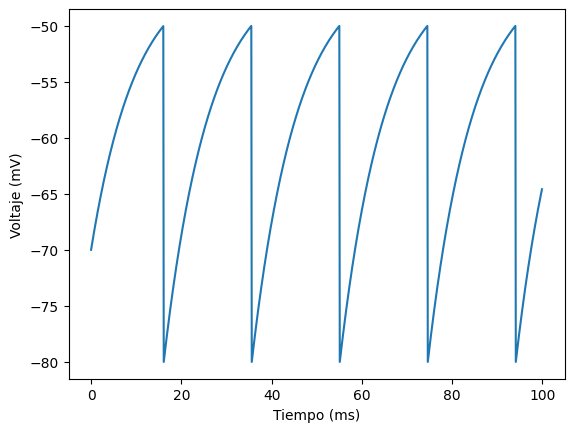

In [1]:
from brian2 import *

# 1. Parámetros
tau = 10*ms
v_rest = -70*mV
v_threshold = -50*mV
v_reset = -80*mV

# 2. Modelo
eqs = 'dv/dt = (v_rest - v + 25*mV) / tau : volt'

# 3. Inicialización
group = NeuronGroup(1, eqs, threshold='v > v_threshold', reset='v = v_reset', method='exact')
group.v = v_rest

# 4. Grabación y Ejecución
monitor = StateMonitor(group, 'v', record=0)
run(100*ms)

# 5. Visualización
import matplotlib.pyplot as plt
plt.plot(monitor.t/ms, monitor.v[0]/mV)
plt.xlabel('Tiempo (ms)')
plt.ylabel('Voltaje (mV)')
plt.show()

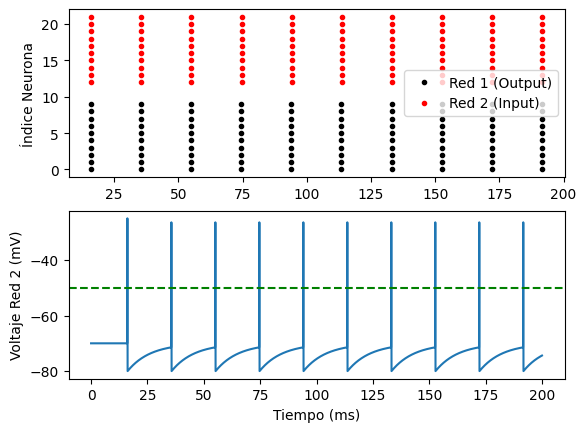

In [4]:
from brian2 import *
import matplotlib.pyplot as plt

# --- 1. CONFIGURACIÓN FÍSICA ---
start_scope() # Limpia la memoria de simulaciones previas

tau = 10*ms
v_rest = -70*mV
v_threshold = -50*mV
v_reset = -80*mV

# Ecuación diferencial: el voltaje tiende al reposo, pero sube con una corriente 'I'
eqs = '''
dv/dt = (v_rest - v + I) / tau : volt
I : volt # Corriente de entrada (señal)
'''

# --- 2. CREACIÓN DE REDES LOCALES ---
# Red 1 (Generadora): 10 neuronas que disparan mucho
Red_1 = NeuronGroup(10, eqs, threshold='v > v_threshold', reset='v = v_reset', method='exact')
Red_1.v = v_rest
Red_1.I = 25*mV  # Le damos corriente constante para que sea activa

# Red 2 (Receptora): 10 neuronas que están en silencio (I = 0)
Red_2 = NeuronGroup(10, eqs, threshold='v > v_threshold', reset='v = v_reset', method='exact')
Red_2.v = v_rest
Red_2.I = 0*mV   # Sin corriente propia, depende de la Red 1

# --- 3. EL ACOPLAMIENTO (Tu DirectedEdge) ---
# Conectamos Red 1 con Red 2. Cuando Red 1 dispara (on_pre), sube el voltaje en Red 2.
# Prueba con un valor mucho más alto para forzar la activación
acoplamiento = Synapses(Red_1, Red_2, on_pre='v_post += 15*mV')
acoplamiento.connect(p=0.5) # Conectamos el 50% de las neuronas aleatoriamente

# --- 4. MONITOREO ---
monitor_1 = SpikeMonitor(Red_1)
monitor_2 = SpikeMonitor(Red_2)
voltaje_2 = StateMonitor(Red_2, 'v', record=0) # Grabamos el voltaje de la neurona 0 de la Red 2

# --- 5. EJECUCIÓN ---
run(200*ms)

# --- 6. VISUALIZACIÓN ---


subplot(211)
plot(monitor_1.t/ms, monitor_1.i, '.k', label='Red 1 (Output)')
plot(monitor_2.t/ms, monitor_2.i + 12, '.r', label='Red 2 (Input)')
plt.ylabel('Índice Neurona')
plt.legend()

subplot(212)
plot(voltaje_2.t/ms, voltaje_2.v[0]/mV)
plt.xlabel('Tiempo (ms)')
plt.ylabel('Voltaje Red 2 (mV)')
plt.axhline(v_threshold/mV, ls='--', color='g', label='Umbral')
plt.show()

Ejecutando Fase 1: Red A activa...
Ejecutando Fase 2: Red A y Red B activas...


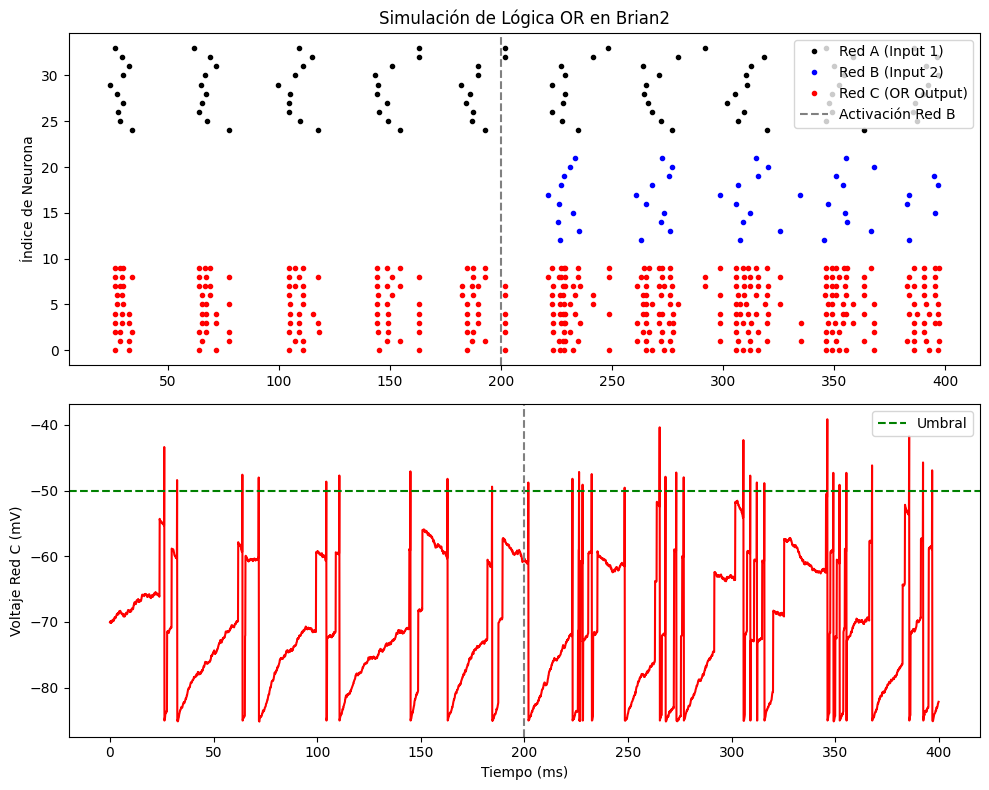

In [6]:
from brian2 import *
import matplotlib.pyplot as plt

# --- 1. CONFIGURACIÓN GLOBAL ---
start_scope()

# Parámetros biofísicos
tau = 20*ms
v_rest = -70*mV
v_threshold = -50*mV
v_reset = -85*mV
sigma = 1.5*mV # Un poco de ruido para realismo

# Ecuación diferencial (Modelo LIF con ruido)
eqs = '''
dv/dt = (v_rest - v + I) / tau + sigma*xi*tau**-0.5 : volt
I : volt
'''

# --- 2. DEFINICIÓN DE LAS REDES (GRUPOS) ---
n_neurons = 10

# Red A: Muy activa (Input 1)
Red_A = NeuronGroup(n_neurons, eqs, threshold='v > v_threshold', reset='v = v_reset', method='euler')
Red_A.v = v_rest
Red_A.I = 25*mV 

# Red B: Menos activa (Input 2) - la activaremos a mitad de simulación
Red_B = NeuronGroup(n_neurons, eqs, threshold='v > v_threshold', reset='v = v_reset', method='euler')
Red_B.v = v_rest
Red_B.I = 0*mV 

# Red C: Receptora (Output OR)
# I = 5mV es insuficiente para disparar por sí sola (necesita ayuda de los acoplamientos)
Red_C = NeuronGroup(n_neurons, eqs, threshold='v > v_threshold', reset='v = v_reset', method='euler')
Red_C.v = v_rest
Red_C.I = 5*mV

# --- 3. ACOPLAMIENTOS (Sinapsis) ---
# Peso de 12mV: Un solo pulso de A o B acerca mucho al umbral, 
# pero la sumación de varios asegura el disparo de C.
S_AC = Synapses(Red_A, Red_C, on_pre='v_post += 12*mV')
S_AC.connect(p=0.8)

S_BC = Synapses(Red_B, Red_C, on_pre='v_post += 12*mV')
S_BC.connect(p=0.8)

# --- 4. MONITORES ---
monitor_A = SpikeMonitor(Red_A)
monitor_B = SpikeMonitor(Red_B)
monitor_C = SpikeMonitor(Red_C)
state_C = StateMonitor(Red_C, 'v', record=0)

# --- 5. EJECUCIÓN EN DOS FASES ---
# Fase 1: Solo Red A está activa
print("Ejecutando Fase 1: Red A activa...")
run(200*ms)

# Fase 2: Activamos también la Red B
print("Ejecutando Fase 2: Red A y Red B activas...")
Red_B.I = 25*mV 
run(200*ms)

# --- 6. VISUALIZACIÓN ---
plt.figure(figsize=(10, 8))

# Gráfico de Spikes (Raster Plot)
plt.subplot(211)
plt.plot(monitor_A.t/ms, monitor_A.i + 24, '.k', label='Red A (Input 1)')
plt.plot(monitor_B.t/ms, monitor_B.i + 12, '.b', label='Red B (Input 2)')
plt.plot(monitor_C.t/ms, monitor_C.i, '.r', label='Red C (OR Output)')
plt.axvline(200, color='gray', ls='--', label='Activación Red B')
plt.ylabel('Índice de Neurona')
plt.title('Simulación de Lógica OR en Brian2')
plt.legend(loc='upper right')

# Gráfico de Voltaje de la Red C
plt.subplot(212)
plt.plot(state_C.t/ms, state_C.v[0]/mV, color='red')
plt.axhline(v_threshold/mV, ls='--', color='green', label='Umbral')
plt.axvline(200, color='gray', ls='--')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Voltaje Red C (mV)')
plt.legend()

plt.tight_layout()
plt.show()

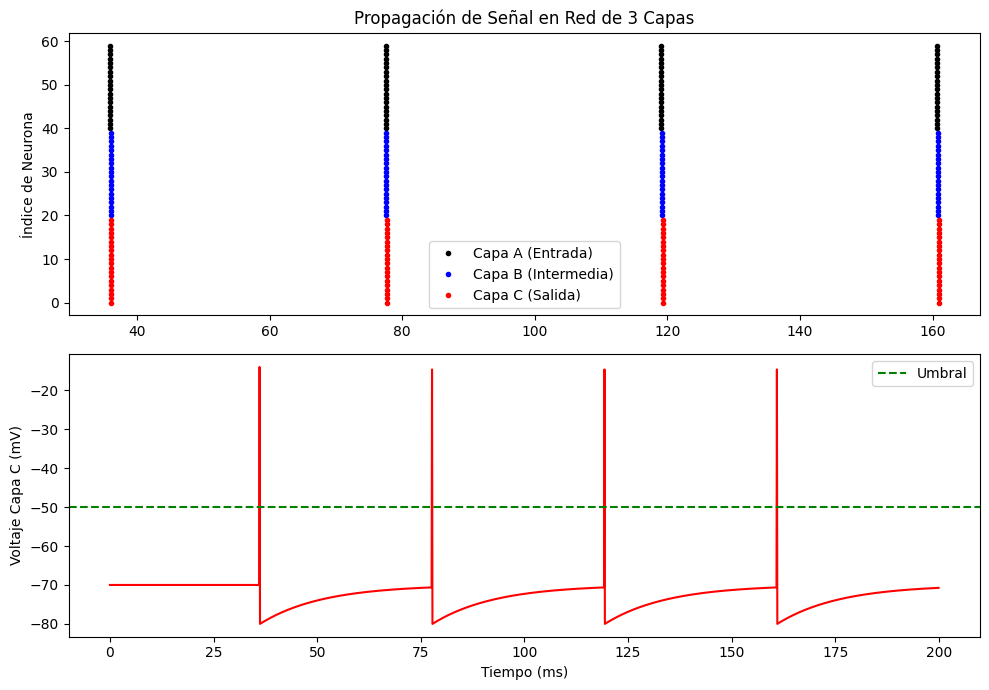

In [8]:
from brian2 import *
import matplotlib.pyplot as plt

# --- 1. CONFIGURACIÓN ---
start_scope()

tau = 15*ms
v_rest = -70*mV
v_threshold = -50*mV
v_reset = -80*mV

# Modelo con una corriente 'I' que definiremos por grupo
# El error ocurría porque faltaba 'I : volt' en la definición
eqs = '''
dv/dt = (v_rest - v + I) / tau : volt
I : volt  # <--- ESTA LÍNEA ES OBLIGATORIA
'''

# --- 2. LAS 3 CAPAS ---
n = 20 # neuronas por capa

Capa_A = NeuronGroup(n, eqs, threshold='v > v_threshold', reset='v = v_reset', method='exact')
Capa_A.v = v_rest
Capa_A.I = 22*mV # Solo la capa A tiene energía externa para empezar

Capa_B = NeuronGroup(n, eqs, threshold='v > v_threshold', reset='v = v_reset', method='exact')
Capa_B.v = v_rest
Capa_B.I = 0*mV  # Depende de A

Capa_C = NeuronGroup(n, eqs, threshold='v > v_threshold', reset='v = v_reset', method='exact')
Capa_C.v = v_rest
Capa_C.I = 0*mV  # Depende de B

# --- 3. CONEXIONES (SINOPSIS) ---
# Conectamos A -> B
S_AB = Synapses(Capa_A, Capa_B, on_pre='v_post += 8*mV')
S_AB.connect(p=0.4) # Conexión dispersa

# Conectamos B -> C
S_BC = Synapses(Capa_B, Capa_C, on_pre='v_post += 8*mV')
S_BC.connect(p=0.4)

# --- 4. MONITORES ---
m_A = SpikeMonitor(Capa_A)
m_B = SpikeMonitor(Capa_B)
m_C = SpikeMonitor(Capa_C)

# Grabamos el voltaje de una neurona de la última capa para ver el retraso
v_C = StateMonitor(Capa_C, 'v', record=0)

# --- 5. EJECUCIÓN ---
run(200*ms)

# --- 6. VISUALIZACIÓN ---
plt.figure(figsize=(10, 7))

# Gráfico de disparos (Raster Plot)
plt.subplot(211)
plt.plot(m_A.t/ms, m_A.i + 40, '.k', label='Capa A (Entrada)')
plt.plot(m_B.t/ms, m_B.i + 20, '.b', label='Capa B (Intermedia)')
plt.plot(m_C.t/ms, m_C.i, '.r', label='Capa C (Salida)')
plt.title('Propagación de Señal en Red de 3 Capas')
plt.ylabel('Índice de Neurona')
plt.legend()

# Voltaje de la última capa
plt.subplot(212)
plt.plot(v_C.t/ms, v_C.v[0]/mV, color='red')
plt.axhline(v_threshold/mV, ls='--', color='green', label='Umbral')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Voltaje Capa C (mV)')
plt.legend()

plt.tight_layout()
plt.show()

WARNING    The object 'synapses_2' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/tmp/ipykernel_20644/636129931.py', line 28, in <module>
    S_AB = Synapses(Capa_A, Capa_B, on_pre='v_post += 10*mV') [brian2.core.base.unused_brian_object]


WARNING    The object 'synapses_3' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/tmp/ipykernel_20644/636129931.py', line 31, in <module>
    S_BC = Synapses(Capa_B, Capa_C, on_pre='v_post += 10*mV') [brian2.core.base.unused_brian_object]
WARNING    The object 'synapses_4' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/tmp/ipykernel_20644/636129931.py', line 35, in <module>
    S_CA = Synapses(Capa_C, Capa_A, on_pre='v_post += 10*mV') [brian2.core.base.unused_brian_object]
WARNING    The object 'neurongroup_7' is getting deleted, but was never included in a network. This 

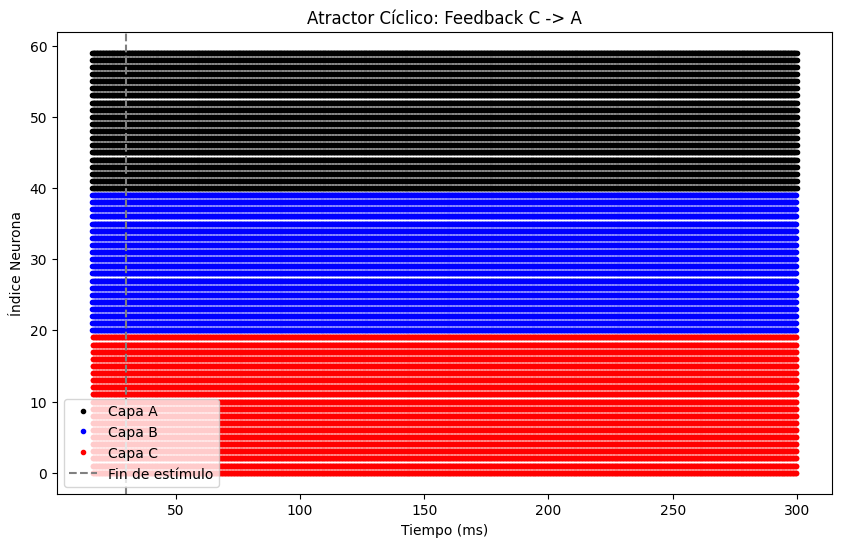

In [10]:
from brian2 import *
import matplotlib.pyplot as plt

start_scope()

# 1. PARÁMETROS
tau = 15*ms
v_rest = -70*mV
v_threshold = -50*mV
v_reset = -80*mV

eqs = '''
dv/dt = (v_rest - v + I) / tau : volt
I : volt
'''

n = 20
# Creamos las capas
Capa_A = NeuronGroup(n, eqs, threshold='v > v_threshold', reset='v = v_reset', method='exact')
Capa_B = NeuronGroup(n, eqs, threshold='v > v_threshold', reset='v = v_reset', method='exact')
Capa_C = NeuronGroup(n, eqs, threshold='v > v_threshold', reset='v = v_reset', method='exact')

# Inicialización
Capa_A.v = Capa_B.v = Capa_C.v = v_rest
Capa_A.I = 0*mV
Capa_B.I = 0*mV
Capa_C.I = 0*mV

# 2. CONEXIONES (SINOPSIS)
# A -> B, B -> C, C -> A
S_AB = Synapses(Capa_A, Capa_B, on_pre='v_post += 12*mV')
S_AB.connect(p=0.6)

S_BC = Synapses(Capa_B, Capa_C, on_pre='v_post += 12*mV')
S_BC.connect(p=0.6)

S_CA = Synapses(Capa_C, Capa_A, on_pre='v_post += 12*mV')
S_CA.connect(p=0.6)

# 3. MONITORES (Uno por cada capa para evitar errores)
m_A = SpikeMonitor(Capa_A)
m_B = SpikeMonitor(Capa_B)
m_C = SpikeMonitor(Capa_C)

# 4. EL "SPARK" (Arranque)
Capa_A.I = 30*mV  # Estimulamos A para empezar el ciclo
run(30*ms)

# Quitamos el estímulo: ahora la red debe mantenerse sola por el feedback de C -> A
Capa_A.I = 0*mV
run(270*ms)

# 5. PLOT
plt.figure(figsize=(10, 6))
plt.plot(m_A.t/ms, m_A.i + 40, '.k', label='Capa A')
plt.plot(m_B.t/ms, m_B.i + 20, '.b', label='Capa B')
plt.plot(m_C.t/ms, m_C.i, '.r', label='Capa C')

plt.axvline(30, color='gray', ls='--', label='Fin de estímulo')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Índice Neurona')
plt.title('Atractor Cíclico: Feedback C -> A')
plt.legend()
plt.show()

Activando inhibición...


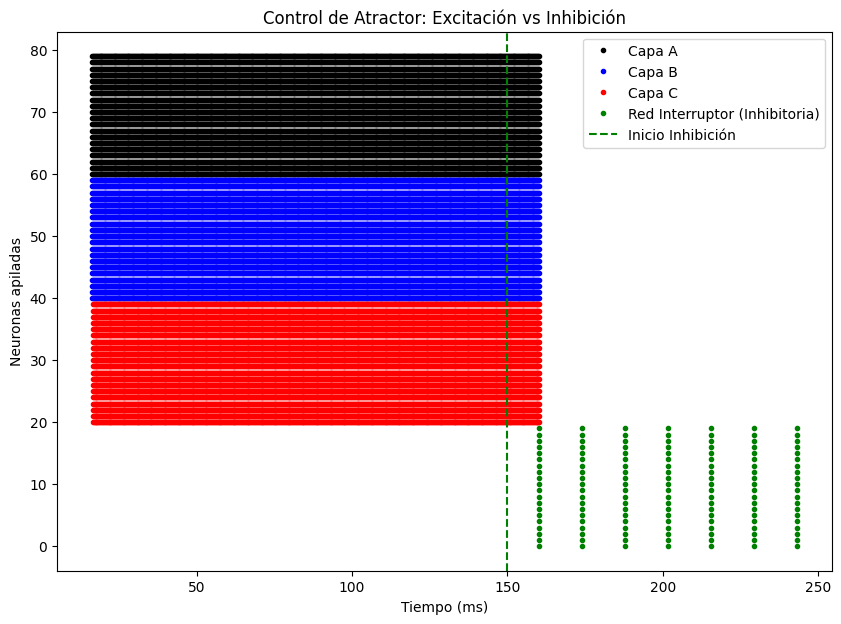

In [11]:
from brian2 import *
import matplotlib.pyplot as plt

start_scope()

# 1. PARÁMETROS
tau = 15*ms
v_rest = -70*mV
v_threshold = -50*mV
v_reset = -80*mV

eqs = '''
dv/dt = (v_rest - v + I) / tau : volt
I : volt
'''

n = 20
# Capas del ciclo
Capa_A = NeuronGroup(n, eqs, threshold='v > v_threshold', reset='v = v_reset', method='exact')
Capa_B = NeuronGroup(n, eqs, threshold='v > v_threshold', reset='v = v_reset', method='exact')
Capa_C = NeuronGroup(n, eqs, threshold='v > v_threshold', reset='v = v_reset', method='exact')

# NUEVA: Red Inhibitoria (El Interruptor)
Red_Interruptor = NeuronGroup(n, eqs, threshold='v > v_threshold', reset='v = v_reset', method='exact')

# Inicialización
Capa_A.v = Capa_B.v = Capa_C.v = Red_Interruptor.v = v_rest
Capa_A.I = Capa_B.I = Capa_C.I = Red_Interruptor.I = 0*mV

# 2. CONEXIONES EXCITATORIAS (El Ciclo)
S_AB = Synapses(Capa_A, Capa_B, on_pre='v_post += 12*mV')
S_AB.connect(p=0.6)
S_BC = Synapses(Capa_B, Capa_C, on_pre='v_post += 12*mV')
S_BC.connect(p=0.6)
S_CA = Synapses(Capa_C, Capa_A, on_pre='v_post += 12*mV')
S_CA.connect(p=0.6)

# 3. CONEXIÓN INHIBITORIA (El Apagado)
# Cuando el Interruptor dispara, resta voltaje a la Capa A (la bloquea)
S_Inhibicion = Synapses(Red_Interruptor, Capa_A, on_pre='v_post -= 25*mV')
S_Inhibicion.connect(p=1.0) # Conexión total para asegurar el apagado

# Monitores
m_A = SpikeMonitor(Capa_A)
m_B = SpikeMonitor(Capa_B)
m_C = SpikeMonitor(Capa_C)
m_Int = SpikeMonitor(Red_Interruptor)

# 4. EJECUCIÓN EN 3 FASES
# Fase 1: Arrancamos el ciclo (0-30ms)
Capa_A.I = 30*mV
run(30*ms)
Capa_A.I = 0*mV # El ciclo ya es autónomo

# Fase 2: El ciclo corre solo (30-150ms)
run(120*ms)

# Fase 3: Activamos el Interruptor para detener el ciclo (150-200ms)
print("Activando inhibición...")
Red_Interruptor.I = 40*mV 
run(100*ms)

# 5. PLOT
plt.figure(figsize=(10, 7))
plt.plot(m_A.t/ms, m_A.i + 60, '.k', label='Capa A')
plt.plot(m_B.t/ms, m_B.i + 40, '.b', label='Capa B')
plt.plot(m_C.t/ms, m_C.i + 20, '.r', label='Capa C')
plt.plot(m_Int.t/ms, m_Int.i, '.g', label='Red Interruptor (Inhibitoria)')

plt.axvline(150, color='green', ls='--', label='Inicio Inhibición')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Neuronas apiladas')
plt.title('Control de Atractor: Excitación vs Inhibición')
plt.legend(loc='upper right')
plt.show()

Ejemplo de datos exportados a Pandas:
   t_ms                                         neuron_idx layer
0  11.2  [4, 2, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1...     A
1  11.6  [4, 2, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1...     A
2  11.6  [4, 2, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1...     A
3  11.9  [4, 2, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1...     A
4  11.9  [4, 2, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1...     A

Matriz booleana (Capa A) generada con forma: (30, 20)


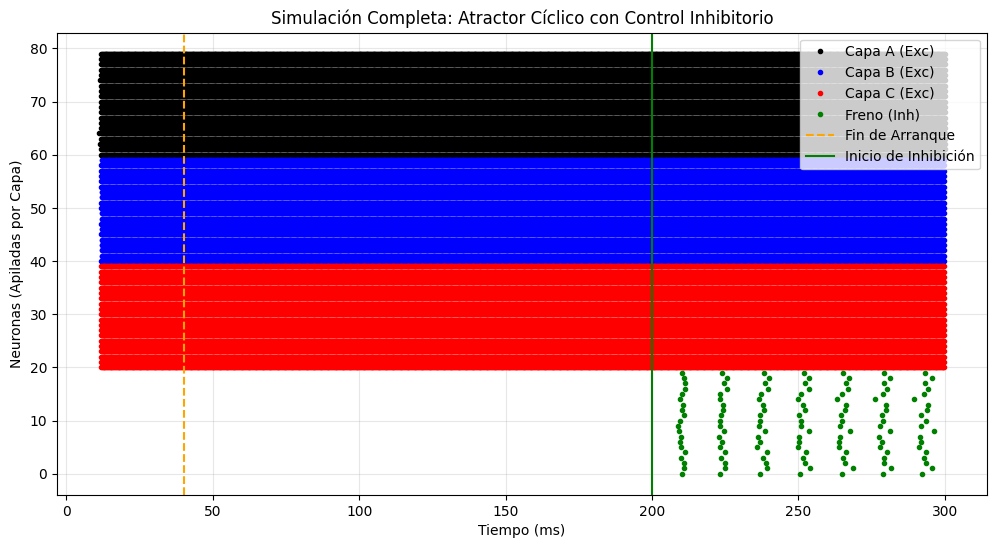

In [12]:
from brian2 import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CONFIGURACIÓN E INSTRUMENTACIÓN ---
start_scope()

# Parámetros físicos
tau = 15*ms
v_rest = -70*mV
v_threshold = -50*mV
v_reset = -80*mV
sigma = 1*mV  # Ruido suave

# Modelo de neurona (LIF con corriente 'I' y Ruido)
eqs = '''
dv/dt = (v_rest - v + I) / tau + sigma*xi*tau**-0.5 : volt
I : volt
'''

n = 20 # Neuronas por capa

# --- 2. CREACIÓN DE LAS REDES ---
Capa_A = NeuronGroup(n, eqs, threshold='v > v_threshold', reset='v = v_reset', method='euler')
Capa_B = NeuronGroup(n, eqs, threshold='v > v_threshold', reset='v = v_reset', method='euler')
Capa_C = NeuronGroup(n, eqs, threshold='v > v_threshold', reset='v = v_reset', method='euler')
Red_Inhibitoria = NeuronGroup(n, eqs, threshold='v > v_threshold', reset='v = v_reset', method='euler')

# Inicializar voltajes y corrientes
for g in [Capa_A, Capa_B, Capa_C, Red_Inhibitoria]:
    g.v = v_rest
    g.I = 0*mV

# --- 3. CONEXIONES (TOPOLOGÍA) ---
# Ciclo Excitatorio: A -> B -> C -> A
S_AB = Synapses(Capa_A, Capa_B, on_pre='v_post += 12*mV')
S_AB.connect(p=0.6)

S_BC = Synapses(Capa_B, Capa_C, on_pre='v_post += 12*mV')
S_BC.connect(p=0.6)

S_CA = Synapses(Capa_C, Capa_A, on_pre='v_post += 12*mV')
S_CA.connect(p=0.6)

# Conexión Inhibitoria: Red_Inhibitoria --| Capa_A
S_Stop = Synapses(Red_Inhibitoria, Capa_A, on_pre='v_post -= 30*mV')
S_Stop.connect(p=1.0)

# --- 4. MONITORES ---
monitor_A = SpikeMonitor(Capa_A)
monitor_B = SpikeMonitor(Capa_B)
monitor_C = SpikeMonitor(Capa_C)
monitor_Inh = SpikeMonitor(Red_Inhibitoria)

# --- 5. SIMULACIÓN POR ETAPAS ---
# Fase 1: Pulso de arranque
Capa_A.I = 35*mV
run(40*ms)

# Fase 2: El ciclo se mantiene solo
Capa_A.I = 0*mV
run(160*ms)

# Fase 3: Activamos el freno (Inhibición)
Red_Inhibitoria.I = 40*mV
run(100*ms)

# --- 6. EXPORTACIÓN DE DATOS ---
# A. A Pandas DataFrame
df_spikes_A = pd.DataFrame({'t_ms': monitor_A.t/ms, 'neuron_idx': monitor_A.i, 'layer': 'A'})
df_spikes_B = pd.DataFrame({'t_ms': monitor_B.t/ms, 'neuron_idx': monitor_B.i, 'layer': 'B'})
df_spikes_total = pd.concat([df_spikes_A, df_spikes_B])

print("Ejemplo de datos exportados a Pandas:")
print(df_spikes_total.head())

# B. A Matriz Binaria (Discretización tipo Booleana)
bin_size = 10*ms
n_bins = int(300*ms / bin_size)
matriz_booleana = np.zeros((n_bins, n))

for t_s, i_n in zip(monitor_A.t, monitor_A.i):
    b_idx = int(t_s / bin_size)
    if b_idx < n_bins:
        matriz_booleana[b_idx, i_n] = 1

print(f"\nMatriz booleana (Capa A) generada con forma: {matriz_booleana.shape}")

# --- 7. VISUALIZACIÓN ---
plt.figure(figsize=(12, 6))
plt.plot(monitor_A.t/ms, monitor_A.i + 60, '.k', label='Capa A (Exc)')
plt.plot(monitor_B.t/ms, monitor_B.i + 40, '.b', label='Capa B (Exc)')
plt.plot(monitor_C.t/ms, monitor_C.i + 20, '.r', label='Capa C (Exc)')
plt.plot(monitor_Inh.t/ms, monitor_Inh.i, '.g', label='Freno (Inh)')

plt.axvline(40, color='orange', ls='--', label='Fin de Arranque')
plt.axvline(200, color='green', ls='-', label='Inicio de Inhibición')
plt.title('Simulación Completa: Atractor Cíclico con Control Inhibitorio')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Neuronas (Apiladas por Capa)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()